# this subdirectory is for analyzing gene expression changes in qPCR data

[not finished]

In [1]:
#importing things
#things for reading in data
import pandas as pd
import csv
from collections import OrderedDict
#things for doing math/stats
import numpy as np
import scipy.stats as stats
#things for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly
import plotly.express as px
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FixedLocator, FixedFormatter

In [2]:
#import data that has been exported by thermo app
robot_data = pd.DataFrame(pd.read_csv('/Users/keith_tetrad/UPR_drug_spike_expression/robot_test_1/robot_test_1_Results_20240213_042615.csv',delimiter=',', usecols=['Sample', 'Target', 'Cq']))
ruimin_data = pd.DataFrame(pd.read_csv('/Users/keith_tetrad/UPR_drug_spike_expression/Ruimin_qPCR/Ruimin_qPCR_Results_20240213_042901.csv',delimiter=',', usecols=['Sample', 'Target', 'Cq']))


In [3]:
# #removing biological replicate information so I can combine them all into one
# #removes -# from each sample

# sample_data['Sample'] = sample_data['Sample'].str.split(' -').str[0]

# #change 4u8c to 4µ8c

# sample_data['Sample']= sample_data['Sample'].replace('4u8c', '4µ8C')
# sample_data['Sample']= sample_data['Sample'].replace('4u8C + dox + Tg', '4µ8C + dox + Tg')
# sample_data['Sample']= sample_data['Sample'].replace('4u8c + Tg', '4µ8C + Tg')
# sample_data['Sample']= sample_data['Sample'].replace('4u8c + dox', '4µ8C + dox')


In [4]:
# #drop Omited samples, as identified in Thermo app, and wells that are 'undetermined'
# filtered = sample_data[sample_data.Omit == False]
# filtered = sample_data[sample_data.Cq != "Undetermined"]
# filtered["Cq"] = pd.to_numeric(filtered["Cq"])
# filtered

In [5]:
#calculate mean and % SEM for technical replicates of each sample and target
mean = (robot_data.groupby(['Sample','Target'], as_index=False)['Cq'].mean()).rename(columns={"Cq": "mean"})
sem = (robot_data.groupby(['Sample','Target'], as_index=False)['Cq'].sem()).rename(columns={"Cq": "sem"})
robot_merged = mean.merge(sem, on = ['Sample','Target'])

#calculate mean and % SEM for technical replicates of each sample and target
mean = (ruimin_data.groupby(['Sample','Target'], as_index=False)['Cq'].mean()).rename(columns={"Cq": "mean"})
sem = (ruimin_data.groupby(['Sample','Target'], as_index=False)['Cq'].sem()).rename(columns={"Cq": "sem"})
ruimin_merged = mean.merge(sem, on = ['Sample','Target'])

Median for Robot: 0.0664091454390646
Median for Ruimin: 0.06408045508457261


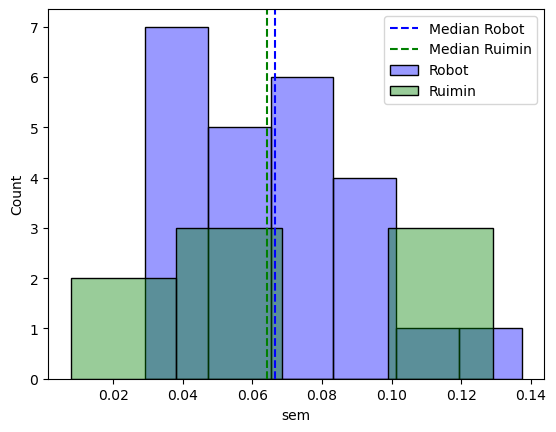

In [6]:
# Filter dataframes
filtered_robot = robot_merged[robot_merged['Target'] == 'RPLP2']
filtered_ruimin = ruimin_merged[ruimin_merged['Target'] == 'RPLP2']

# Create histograms
sns.histplot(filtered_robot['sem'], color='blue', alpha=0.4, label='Robot')
sns.histplot(filtered_ruimin['sem'], color='green', alpha=0.4, label='Ruimin')

# Calculate medians
median1 = np.median(filtered_robot['sem'])
median2 = np.median(filtered_ruimin['sem'])

# Add median lines
plt.axvline(median1, color='blue', linestyle='--', label='Median Robot')
plt.axvline(median2, color='green', linestyle='--', label='Median Ruimin')

# Print medians
print(f"Median for Robot: {median1}")
print(f"Median for Ruimin: {median2}")

# Add legend
plt.legend()

#plt.savefig("ruimin_vs_robot_sem_RPLP2.png")  # You can specify a different file name and format (e.g., 'histogram.jpg', 'histogram.pdf')

plt.show()


Median for Robot: 0.0857386958836773
Median for Ruimin: 0.07952143894219857


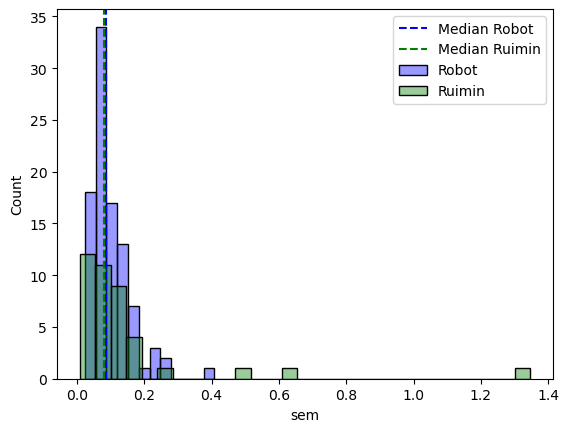

In [7]:
# Create histograms
sns.histplot(robot_merged['sem'], color='blue', alpha=0.4, label='Robot')
sns.histplot(ruimin_merged['sem'], color='green', alpha=0.4, label='Ruimin')

# Calculate medians
median1 = np.median(robot_merged['sem'])
median2 = np.median(ruimin_merged['sem'])

# Add median lines
plt.axvline(median1, color='blue', linestyle='--', label='Median Robot')
plt.axvline(median2, color='green', linestyle='--', label='Median Ruimin')

# Print medians
print(f"Median for Robot: {median1}")
print(f"Median for Ruimin: {median2}")

# Add legend
plt.legend()

#plt.savefig("ruimin_vs_robot_sem.png")  # You can specify a different file name and format (e.g., 'histogram.jpg', 'histogram.pdf')

plt.show()


Keith's code starts here

In [8]:
#for each sample, normalize to RPPL2 and propagate error
#normalize to RPL2: mean - RPL2_mean for each target within a sample group
#iloc position points to RPL2 within each sample grouping

#set the house keeping gene here
house_keeping_gene = 'RPLP2'

#when I group by sample, this indicates where the RPLP2 sample is
house_keeping_gene_row = robot_merged[robot_merged['Target'] == 'RPLP2'].index[0]

#when I group by sample subtracts the RPLP2 mean from the mean of the other samples 
robot_merged['mean_normalized_house_keeping'] = robot_merged.groupby('Sample')['mean'].apply(lambda x: x - x.iloc[house_keeping_gene_row])

#propogating error: sqrt(sem^2 - sem_hk_gene^2)
robot_merged['sem_normalized_house_keeping'] = robot_merged.groupby('Sample')['sem'].apply(lambda x: np.sqrt(x**2 + x.iloc[house_keeping_gene_row]**2))

#remove RPLP2 samples from the dataframe
robot_merged = robot_merged.groupby('Sample').apply(lambda x: x.drop(x.index[house_keeping_gene_row])).reset_index(drop=True)


/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/2519251006.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  robot_merged['mean_normalized_house_keeping'] = robot_merged.groupby('Sample')['mean'].apply(lambda x: x - x.iloc[house_keeping_gene_row])
/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/2519251006.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

In [10]:
# Extract the base 'pRH' identifier to identify unique cell lines
cell_line_groups = robot_merged['Sample'].str.extract(r'(pRH\d+)')[0].unique()

sample_normalized = pd.DataFrame()

for cell_line in cell_line_groups:
    cell_data = robot_merged[robot_merged['Sample'].str.startswith(cell_line)]
    
    #determine reference sample
    ref_id = ' + DMSO - 1'
    reference_sample = cell_data[cell_data['Sample'].str.endswith(ref_id)]
    
    #adding coluns with reference mean + sem
    cell_data = cell_data.merge(reference_sample[['Target','mean_normalized_house_keeping']], on='Target', suffixes=('', '_ref'))
    cell_data = cell_data.merge(reference_sample[['Target','sem_normalized_house_keeping']], on='Target', suffixes=('', '_ref'))

    #relative quantification: 2^-(mean - ref_mean)
    cell_data['Relative Quantification'] = 2**(-(cell_data['mean_normalized_house_keeping'] - cell_data['mean_normalized_house_keeping_ref']))

    #propogating error: sqrt(sem^2 - ref_sem^2)
    cell_data['sem_normalized_ref'] = np.sqrt(cell_data['sem_normalized_house_keeping']**2 + cell_data['sem_normalized_house_keeping_ref']**2)

    # Append cell_data to merged
    sample_normalized  = sample_normalized .append(cell_data)

    # Now, merged has the columns, and you can create sample_normalized
    merged = sample_normalized .loc[:, ['Sample','Target','Relative Quantification','sem_normalized_house_keeping','sem_normalized_ref']]

    # If you intended to replace merged with sample_normalized
    sample_normalized  = merged

sample_normalized

/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/2568569142.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_normalized  = sample_normalized .append(cell_data)
/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/2568569142.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_normalized  = sample_normalized .append(cell_data)
/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/2568569142.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_normalized  = sample_normalized .append(cell_data)


,Sample,Target,Relative Quantification,sem_normalized_house_keeping,sem_normalized_ref
0,pRH106 + 4u8c - 1,RBD,0.639124,0.167003,0.295241
1,pRH106 + 4u8c - 2,RBD,0.485222,0.198430,0.314089
2,pRH106 + Both - 1,RBD,0.630635,0.131111,0.276527
3,pRH106 + Both - 2,RBD,0.753198,0.430529,0.494603
4,pRH106 + C7 - 1,RBD,0.671509,0.175512,0.300136
...,...,...,...,...,...
19,pRH112 + Both - 2,mCherry,0.645478,0.135345,0.179567
20,pRH112 + C7 - 1,mCherry,0.935172,0.086557,0.146349
21,pRH112 + C7 - 2,mCherry,1.116553,0.070900,0.137669
22,pRH112 + DMSO - 1,mCherry,1.000000,0.118008,0.166889


In [18]:
# Extract the base 'pRH' identifier to identify unique cell lines
cell_line_groups = robot_merged['Sample'].str.extract(r'(pRH\d+)')[0].unique()

sample_normalized = pd.DataFrame()

# Define the custom order
custom_order = [' + DMSO - 1', ' + DMSO - 2', ' + 4u8c - 1', ' + 4u8c - 2', ' + C7 - 1', ' + C7 - 2', ' + Both - 1', ' + Both - 2']

# Custom sorting function
def sort_key(sample):
    for index, name in enumerate(custom_order):
        if name in sample:
            return index
    return len(custom_order)  # In case a sample name does not match any in the custom_order

for cell_line in cell_line_groups:
    cell_data = robot_merged[robot_merged['Sample'].str.startswith(cell_line)]
    
    # Determine reference sample
    ref_id = ' + DMSO - 1'
    reference_sample = cell_data[cell_data['Sample'].str.endswith(ref_id)]
    
    # Adding columns with reference mean + sem
    cell_data = cell_data.merge(reference_sample[['Target', 'mean_normalized_house_keeping']], on='Target', suffixes=('', '_ref'))
    cell_data = cell_data.merge(reference_sample[['Target', 'sem_normalized_house_keeping']], on='Target', suffixes=('', '_ref'))

    # Relative quantification: 2^-(mean - ref_mean)
    cell_data['Relative Quantification'] = 2**(-(cell_data['mean_normalized_house_keeping'] - cell_data['mean_normalized_house_keeping_ref']))

    # Propagating error: sqrt(sem^2 - ref_sem^2)
    cell_data['sem_normalized_ref'] = np.sqrt(cell_data['sem_normalized_house_keeping']**2 + cell_data['sem_normalized_house_keeping_ref']**2)

    # Sort the cell_data within each cell_line
    cell_data['sort_key'] = cell_data['Sample'].apply(sort_key)
    cell_data = cell_data.sort_values(by=['sort_key', 'Sample'])
    cell_data.drop('sort_key', axis=1, inplace=True)

    # Append cell_data to sample_normalized
    sample_normalized = sample_normalized.append(cell_data)

# Selecting the necessary columns
sample_normalized = sample_normalized[['Sample', 'Target', 'Relative Quantification', 'sem_normalized_house_keeping', 'sem_normalized_ref']]

/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/122487820.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_normalized = sample_normalized.append(cell_data)
/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/122487820.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_normalized = sample_normalized.append(cell_data)
/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_59820/122487820.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_normalized = sample_normalized.append(cell_data)


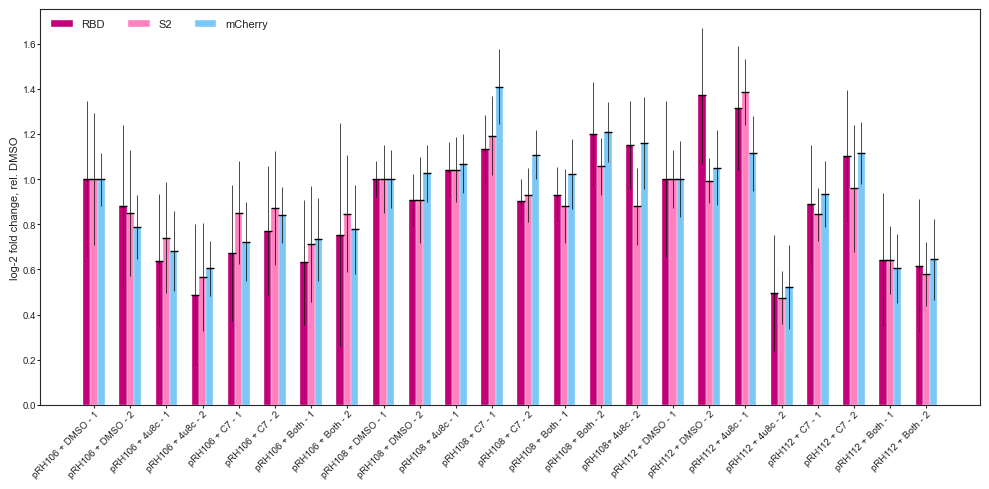

In [20]:
# Set up the plot formatting
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 5))
plt.tick_params(size=2, labelsize=7, length=2.5, pad=1)
width = 0.2

# Define colors
RBD_color = '#C20078'
S2_color = '#FF81C0'
mCherry_color = '#7BC8F6'

# Get unique sample names for plot
axes_titles = sample_normalized.Sample.unique().tolist()
x = np.arange(len(axes_titles))

# Parse data by target into lists
RBD = sample_normalized.loc[sample_normalized["Target"] == "RBD"]["Relative Quantification"].tolist()
RBD_sem = sample_normalized.loc[sample_normalized["Target"] == "RBD"]["sem_normalized_ref"].tolist()

S2 = sample_normalized.loc[sample_normalized["Target"] == "S2"]["Relative Quantification"].tolist()
S2_sem = sample_normalized.loc[sample_normalized["Target"] == "S2"]["sem_normalized_ref"].tolist()

mCherry = sample_normalized.loc[sample_normalized["Target"] == "mCherry"]["Relative Quantification"].tolist()
mCherry_sem = sample_normalized.loc[sample_normalized["Target"] == "mCherry"]["sem_normalized_ref"].tolist()

# Iterate through targets to plot
for xval in x:
    plt.bar(xval - width, RBD[xval], width, color=RBD_color, linewidth=0.25)
    plt.bar(xval, S2[xval], width, color=S2_color, linewidth=0.25)
    plt.bar(xval + width, mCherry[xval], width, color=mCherry_color, linewidth=0.25)

    # Add error bars
    plt.errorbar(xval - width, RBD[xval], yerr=RBD_sem[xval], fmt='k_', linewidth=0.5)
    plt.errorbar(xval, S2[xval], yerr=S2_sem[xval], fmt='k_', linewidth=0.5)
    plt.errorbar(xval + width, mCherry[xval], yerr=mCherry_sem[xval], fmt='k_', linewidth=0.5)

# Customize the plot
plt.xticks(x, axes_titles, fontsize=7, rotation=45, ha='right', rotation_mode="anchor")
plt.yticks(fontsize=7)
plt.xlabel('', fontsize=8)
plt.ylabel('log-2 fold change, rel. DMSO', labelpad=2, fontsize=8)

# Create a legend
legend_elements = [Patch(facecolor=RBD_color, label='RBD'),
                   Patch(facecolor=S2_color, label='S2'),
                   Patch(facecolor=mCherry_color, label='mCherry')]

plt.legend(handles=legend_elements, fontsize=8, loc='upper left', ncol=3, frameon=False)

plt.axhline(y=0, linestyle='dashed', c='black', linewidth=0.5)
plt.tight_layout()

# Uncomment the next line to save the plot as a PDF
plt.savefig('robot_qPCR_results.pdf')

plt.show()


In [ ]:
#make a new dataframe for startistics
statistics = sample_normalized[['Sample','Target']].copy()

# Using stats equations from: https://www.peggykern.org/uploads/5/6/6/7/56678211/ttestformulas.pdf

# Compute pooled standard error
# Pooled standard error = sqrt(sem1^2 + sem2^2)
#sem = stdv/sqrt(6) where N = 6

statistics['pooled_sem'] = np.sqrt((((merged['stdev_normalized_house_keeping']/2.4494897428)**2) + ((merged['stdev_normalized_house_keeping_ref']/2.4494897428)**2)))

# Compute t-statistic
# t = (mean1 - mean2)/pooled sem
statistics['t_statistics'] = (merged['mean_normalized_house_keeping']-merged['mean_normalized_house_keeping_ref']) / statistics['pooled_sem']

# Compute degrees of freedom
# df = number of subjects - 2
df = 6 + 6 - 2

# Compute p-value
statistics['p_value'] = 2 * (1 - stats.t.cdf(abs(statistics['t_statistics']), df))